In [1]:
%%capture
# https://github.com/noahberhe/Lobbyists4America/blob/master/Lobbyists4America.ipynb

!pip install textblob
!pip install findspark
!pip install nltk
!pip install wordcloud
!pip install geopy
!pip install folium
#!pip install plotly
!pip install chart_studio
!pip install plotly jupyterlab
!pip install "plotly>=5" "ipywidgets>=7.6"
!pip install chart_studio
# !pip install plotly jupyterlab
#!jupyter labextension install @jupyterlab/plotly-extension
!jupyter labextension install plotlywidget
#!pip install -U nltk
#!python -m nltk.downloader popular -d 'gs://cloud-project-bucket-1981/stopwords'

In [2]:
# %%capture
!jupyter labextension list

JupyterLab v0.35.0
Known labextensions:
   app dir: /opt/conda/miniconda3/share/jupyter/lab
        @jupyterlab/plotly-extension v1.0.0  enabled  OK
        jupyterlab-dash v0.4.1  enabled   X
        nbdime-jupyterlab v2.1.1  enabled   X
        plotlywidget v4.14.3  enabled  OK

"jupyterlab-dash@0.4.1" is not compatible with the current JupyterLab
Conflicting Dependencies:
JupyterLab              Extension        Package
>=0.19.1 <0.20.0        >=2.0.0 <3.0.0||>=3.0.0 <4.0.0@jupyterlab/application
>=0.19.1 <0.20.0        >=2.0.0 <3.0.0||>=3.0.0 <4.0.0@jupyterlab/notebook
>=0.19.1 <0.20.0        >=2.0.0 <3.0.0||>=3.0.0 <4.0.0@jupyterlab/console



"nbdime-jupyterlab@2.1.1" is not compatible with the current JupyterLab
Conflicting Dependencies:
JupyterLab             Extension        Package
>=0.19.1 <0.20.0       >=2.0.0 <3.0.0||>=3.0.0 <4.0.0@jupyterlab/apputils
>=2.2.1 <3.0.0         >=4.0.0 <5.0.0||>=5.0.0 <6.0.0@jupyterlab/coreutils
>=0.19.1 <0.20.0       >=2.0.0 <3.0.0||>=3.0.0 <

In [3]:
%%capture
!pip install jupyterlab_dash

In [4]:
# %%capture
!jupyter serverextension install jupyter_server_proxy
!jupyter serverextension enable jupyter_server_proxy

Please supply at least one subcommand: disable, enable, list
Enabling: jupyter_server_proxy
- Writing config: /root/.jupyter
    - Validating...
      jupyter_server_proxy  OK


In [5]:
%%capture
# import necessary packages
import os
import json
import time
import subprocess
import pyspark
import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from textblob import TextBlob
# https://stackoverflow.com/questions/36969991/folium-map-not-displaying
import webbrowser
"""
import nltk
nltk.download('stopwords')
#nltk.download('stopwords',download_dir='gs://cloud-project-bucket-1981/stopwords')
nltk.data.path.append('gs://cloud-project-bucket-1981/stopwords')
from nltk.corpus import stopwords
"""
import nltk
# from nltk.corpus import stopwords
# nltk.data.path.append('gs://cloud-project-bucket-1981/stopwords')
# nltk.download('stopwords',download_dir='gs://cloud-project-bucket-1981/stopwords')

"""
# Data is downloaded to /root/nltk_data/corpora/stopwords.zip
from zipfile import ZipFile
# OSError: No such file or directory: '/root/nltk_data/corpora/stopwords/english'
file_loc = '/root/nltk_data/corpora/stopwords.zip'
with ZipFile(file_loc, 'r') as z:
    z.extractall('/root/nltk_data/corpora/')
"""    

#import libraries to visualize the results from stream
import time
from IPython import display
from IPython.display import IFrame
from IPython.display import clear_output
import plotly
# import plotly.plotly as py
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import ast
import numpy as np
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut
import folium
from folium import plugins
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMapWithTime
%matplotlib inline

In [6]:
findspark.init()

In [7]:
def json_load(text):
    return json.loads(text)

In [8]:
def get_message(text):
    msg = json.loads(text)
    # if tweet is longer than 140 characters
    if "extended_tweet" in msg:
        return str(msg['extended_tweet']['full_text'])
    else:
        return str(msg['text'])

In [9]:
def get_tweet_field(text, field):
    msg = json.loads(text)
    if '/' in field:
        fields = field.split('/')
        fieldDepth = len(fields)
        f = msg
        for i in range(fieldDepth):
            if(f is None):
                return None
            if i == fieldDepth - 1:
                return str(f[fields[i]]) 
            else:
                f = f[fields[i]]
    else:
        return str(msg[field])

In [10]:
def get_analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [11]:
def remove_stopwords(x):    
    # data = nltk.corpus.comtrans.aligned_sents('alignment-en-fr.txt')
    # nltk.data.path.append('gs://cloud-project-bucket-1981/stopwords')
    sw = nltk.corpus.stopwords.words("english")
    string = ''
    for x in x.split(' '):
        if x.lower() not in sw:
            string += x + ' '
        else:
            pass
    return string


In [12]:
def process_tweets(tweets):
    
    # Convert to json
    json_load_udf = udf(json_load, StringType())
    tweets = tweets.withColumn("json", json_load_udf("value"))
    
    # Get id
    get_tweet_field_udf = udf(get_tweet_field, StringType())
    tweets = tweets.withColumn("id", get_tweet_field_udf("value", lit('id')))
    
    # Get created_at
    get_tweet_field_udf = udf(get_tweet_field, StringType())
    tweets = tweets.withColumn("created_at", get_tweet_field_udf("value", lit('created_at')))
    
    # Get place full name
    get_tweet_field_udf = udf(get_tweet_field, StringType())
    tweets = tweets.withColumn("place_full_name", get_tweet_field_udf("value", lit('place/full_name')))
    
    # Get place country
    get_tweet_field_udf = udf(get_tweet_field, StringType())
    tweets = tweets.withColumn("place_country", get_tweet_field_udf("value", lit('place/country')))
    
    # Get place country code
    get_tweet_field_udf = udf(get_tweet_field, StringType())
    tweets = tweets.withColumn("place_country_code", get_tweet_field_udf("value", lit('place/country_code')))
    
    # Get place co-ordinates
    get_tweet_field_udf = udf(get_tweet_field, StringType())
    tweets = tweets.withColumn("place_coordinates", get_tweet_field_udf("value", lit('coordinates')))
    
    # Get place bounding_box co-ordinates
    get_tweet_field_udf = udf(get_tweet_field, StringType())
    tweets = tweets.withColumn("bounding_box_coordinates", get_tweet_field_udf("value", lit('place/bounding_box/coordinates')))
    
    # Get place type
    get_tweet_field_udf = udf(get_tweet_field, StringType())
    tweets = tweets.withColumn("place_type", get_tweet_field_udf("value", lit('place/place_type')))
    
    # Get message
    get_message_udf = udf(get_message, StringType())
    tweets = tweets.withColumn("message", get_message_udf("value"))
    
    # Get cleaned words from message for analysis
    #tweets = tweets.na.replace('', None)
    #tweets = tweets.na.drop()
    tweets = tweets.withColumn('words', tweets.message)
    tweets = tweets.withColumn('words', F.regexp_replace('words', r'http\S+', ' '))
    tweets = tweets.withColumn('words', F.regexp_replace('words', '@\w+', ' '))
    tweets = tweets.withColumn('words', F.regexp_replace('words', '#', ' '))
    tweets = tweets.withColumn('words', F.regexp_replace('words', 'RT', ''))
    tweets = tweets.withColumn('words', F.regexp_replace('words', ':', ' '))
    # tweets = tweets.withColumn('words', F.regexp_replace('words', '.', ' '))
    # print(tweets.schema['words'].dataType)
   
    # my_udf = udf(lambda x: remove_stopwords(x), StringType())
    # tweets = tweets.withColumn('words',my_udf(tweets.words))

    # Drop unnesscessary data
    tweets = tweets.drop("value")
    tweets = tweets.drop("json")
    
    return tweets

In [13]:
# Text classification using TextBlob
def polarity_detection(text):
    return TextBlob(text).sentiment.polarity
def subjectivity_detection(text):
    return TextBlob(text).sentiment.subjectivity
def text_classification(tweets):
    
    # polarity detection
    polarity_detection_udf = udf(polarity_detection, StringType())
    tweets = tweets.withColumn("polarity", polarity_detection_udf("words"))
    
    # subjectivity detection
    subjectivity_detection_udf = udf(subjectivity_detection, StringType())
    tweets = tweets.withColumn("subjectivity", subjectivity_detection_udf("words"))
    
    # analysis
    get_analysis_udf = udf(get_analysis, StringType())
    tweets = tweets.withColumn('analysis', get_analysis_udf('polarity'))
    
    return tweets

In [14]:
# %%capture
"""
def flat_list(column):
    corpus = []
    for row in column:
        for w in row.split(' '):
            corpus.append(w)
    return corpus

def corpus_creator(text_col):
    corpus = text_col.rdd \
                    .flatMap(flat_list) \
                    .map(lambda x: (x, 1)) \
                    .reduceByKey(lambda x, y: x+y ) \
                    .sortBy(lambda x: x[1], ascending=False) \
                    .toDF() \
                    .withColumnRenamed('_1','text') \
                    .withColumnRenamed('_2','count')
    return corpus

def annual_tweets(year, tweets):
    annual_tweets = tweets.select('words') \
                        .filter('YEAR(FROM_UNIXTIME(created_at))=={}'.format(year)) \
                        .withColumnRenamed('words','text')
    # print(annual_tweets.head(3))
    return annual_tweets

def wordcloud(corpus_sdf):
    corpus_pdf = corpus_sdf.limit(500).toPandas()

    corpus_dict = {}
    for index, row in corpus_pdf.iterrows():
        corpus_dict[row['text']] = row['count']
        
    wordcloud = WordCloud().generate_from_frequencies(corpus_dict)
    plt.imshow(wordcloud);

def annualcorpora(tweets):
    years_list = [2022]
    print(tweets["id"].head(3))
    annual_corpora = {}
    for year in years_list:
        annual_corpora[str(year)] = corpus_creator(annual_tweets(year, tweets))

    for key,value in annual_corpora.items():
        fig, ax = plt.subplots()
        ax = wordcloud(value)
        fig.suptitle('{} wordcloud'.format(key))
"""

'\ndef flat_list(column):\n    corpus = []\n    for row in column:\n        for w in row.split(\' \'):\n            corpus.append(w)\n    return corpus\n\ndef corpus_creator(text_col):\n    corpus = text_col.rdd                     .flatMap(flat_list)                     .map(lambda x: (x, 1))                     .reduceByKey(lambda x, y: x+y )                     .sortBy(lambda x: x[1], ascending=False)                     .toDF()                     .withColumnRenamed(\'_1\',\'text\')                     .withColumnRenamed(\'_2\',\'count\')\n    return corpus\n\ndef annual_tweets(year, tweets):\n    annual_tweets = tweets.select(\'words\')                         .filter(\'YEAR(FROM_UNIXTIME(created_at))=={}\'.format(year))                         .withColumnRenamed(\'words\',\'text\')\n    # print(annual_tweets.head(3))\n    return annual_tweets\n\ndef wordcloud(corpus_sdf):\n    corpus_pdf = corpus_sdf.limit(500).toPandas()\n\n    corpus_dict = {}\n    for index, row in corpus_pdf.

In [15]:
def wordcloud_creator(tweets):
    # https://www.analyticsvidhya.com/blog/2021/08/creating-customized-word-cloud-in-python/
    # Create stopword
    stopwords = set(STOPWORDS)
    text = " ".join(review for review in tweets.words.astype(str))
    wordcloud = WordCloud(max_font_size=50, max_words=150, background_color="black", stopwords = STOPWORDS).generate(text)
    #Display the image
    plt.imshow(wordcloud, interpolation="bilinear")
    # plt.figure()
    plt.axis("off")
    plt.clf()
    


In [16]:
# https://github.com/RonKG/Machine-Learning-Projects-2/blob/master/3.%20NLP_twitter_sentiment_analysis/FINAL____twitter_sentiment_twitter.ipynb
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())


def data_details(data):
    # print(data.head(2))
    # check the number of positive vs. negative tagged sentences
    positives = data['analysis'][data.analysis == "Positive"]
    negatives = data['analysis'][data.analysis == "Negative"]

    print('number of positve tagged sentences is:  {}'.format(len(positives)))
    print('number of negative tagged sentences is: {}'.format(len(negatives)))
    print('total length of the data is:            {}'.format(data.shape[0]))
    data['word count'] = data['words'].apply(word_count)
    # plot word count distribution for both positive and negative sentiments
    x = data['word count'][data.analysis == "Positive"]
    y = data['word count'][data.analysis == "Negative"]
    plt.figure(figsize=(12,6))
    plt.xlim(0,45)
    plt.xlabel('word count')
    plt.ylabel('frequency')
    g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
    plt.legend(loc='upper right')
    plt.clf()
    

In [17]:
def common_words(data):
    # get most common words in training dataset
    all_words = []
    for line in list(data['words']):
        words = line.split()
        for word in words:
            all_words.append(word.lower())
    return all_words
   
    print(Counter(all_words).most_common(10))

In [18]:
def word_freq_plot(data):
    # plot word frequency distribution of first few words
    all_words=common_words(data)
    plt.figure(figsize=(12,5))
    plt.title('Top 25 most common words')
    plt.xticks(fontsize=13, rotation=90)
    fd = nltk.FreqDist(all_words)
    fd.plot(25,cumulative=False)
    plt.clf()

    # log-log plot
    word_counts = sorted(Counter(all_words).values(), reverse=True)
    plt.figure(figsize=(12,5))
    plt.loglog(word_counts, linestyle='-', linewidth=1.5)
    plt.ylabel("Freq")
    plt.xlabel("Word Rank")
    plt.title('log-log plot of words frequency')
    plt.clf()
    

In [19]:
def sent_number (row):
    if row['analysis'] == "Positive" :
        #print ("Positive")
        return 1
    if row['analysis'] == "Negative" :
        #print ("Negative")
        return 0
    if row['analysis'] == "Neutral" :
        #print ("Neutral")
        return None
   

In [20]:
# get central geo location from the bounding box for later mapping

# helper function to get mean of lats and longs
def geo_mean(x):
    y = json.loads(x)
    y = np.asarray(y)
    mean_geoloc = np.add(np.add((y[:][0][0]),(y[:][0][1]))/2,\
                         (np.add((y[:][0][2]),(y[:][0][3]))/2))/2    
    return np.around(mean_geoloc,decimals=6)


In [21]:
def do_geocode(address, attempt=1, max_attempts=10):
    try:
        return geopy.geocode(address)
    except GeocoderTimedOut:
        if attempt <= max_attempts:
            return do_geocode(address, attempt=attempt+1)
        raise

In [22]:

# https://www.geeksforgeeks.org/how-to-get-geolocation-in-python/
# importing geopy library
# 
def get_place_coords(place):
    # calling the Nominatim tool
    loc = Nominatim(user_agent="GetLoc")
    
    # adding a delay to avoid a Too Many Requests error
    # https://geopy.readthedocs.io/en/stable/#usage-with-pandas
    geocode = RateLimiter(loc.geocode, min_delay_seconds=1)
    
    # entering the location name
    # getLoc = place.apply(geocode)
    if geocode(place):
        getLoc = geocode(place)
        # print(getLoc)
        return([getLoc.longitude,getLoc.latitude])
    else:
        return None
 
    # printing address
    #print(getLoc.address)
 
    # printing latitude and longitude
    #print("Latitude = ", getLoc.latitude, "\n")
    #print("Longitude = ", getLoc.longitude)
    
    


In [23]:
# get latitudes and longitudes

# some helper funtions to get longs and lats
def lats(x):
    return x[1]

def longs(x):
    return x[0]

# --------------------------------------------------------#
def get_lat_longs(df):
# append longs and lats to dframe
    df['latitude'] = df['geo_code'].apply(lats)
    df['longitude'] = df['geo_code'].apply(longs)
    return(df)


In [24]:
# http://www.mikaelbrunila.fi/2017/03/27/scraping-extracting-mapping-geodata-twitter/
# Note that the “coordinates” attributes is formatted as [LONGITUDE, latitude],
"""
['id' 'date' 'full_name' 'country' 'country_code' 'coordinates'
 'bbox_coords' 'place_type' 'message' 'message' 'polarity' 'subjectivity'
 'analysis']
"""
def geo_data(df):
    # print(df['coordinates'].head(10))
    # print(df.columns.values)
    df = df.reset_index()
    df["geo_code"] = np.nan
    count=0
    lst = []
    for a in range(1):
        lst.append([1, 2, 3])

    for index, tweet in df.iterrows():
        # tweet_fullname=tweet['full_name']
        if tweet['coordinates'] != "None":
            #print("Hello")
            #print(tweet['coordinates'])
            #print(type(tweet['coordinates']))
            new_dict=ast.literal_eval(tweet['coordinates'])
            # print(new_dict.get('coordinates'))
            tweet["geo_code"]=new_dict.get('coordinates')
            lst.append(tweet)
            #print(df["geo_code"].get('coordinates') )
            
        elif tweet['full_name']:
            # print("Got in here")
            place=tweet['full_name']
            # print(place)
            long_lat=get_place_coords(place)
            if long_lat != None:
                tweet["geo_code"]=long_lat
                lst.append(tweet)
                # print(long_lat)
        
        elif tweet['country']:
            #print("Got in here")
            place=tweet['country']
            # print(place)
            long_lat=get_place_coords(place)
            if long_lat != None:
                tweet["geo_code"]=long_lat
                lst.append(tweet)
                # print(long_lat)
                
        else:
            pass
      

        
    
    # columns= df.columns.values.tolist()
    geo_data_df = pd.DataFrame(lst, columns= df.columns.values.tolist())
    geo_data_df = geo_data_df.iloc[1: , :]
    geo_data_df = get_lat_longs(geo_data_df)
    # print(geo_data_df.head(3))
    
    return(geo_data_df)
    



In [25]:
def get_state(x):
    
    states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
              "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
              "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
              "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
              "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

    states_dict = {
            'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa',
            'AZ': 'Arizona','CA': 'California','CO': 'Colorado','CT': 'Connecticut',
            'DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida','GA': 'Georgia',
            'GU': 'Guam','HI': 'Hawaii','IA': 'Iowa','ID': 'Idaho','IL': 'Illinois',
            'IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana',
            'MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan',
            'MN': 'Minnesota','MO': 'Missouri','MP': 'Northern Mariana Islands',
            'MS': 'Mississippi','MT': 'Montana','NA': 'National','NC': 'North Carolina',
            'ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey',
            'NM': 'New Mexico','NV': 'Nevada','NY': 'New York','OH': 'Ohio','OK': 'Oklahoma',
            'OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico','RI': 'Rhode Island',
            'SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas',
            'UT': 'Utah','VA': 'Virginia','VI': 'Virgin Islands','VT': 'Vermont',
            'WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'
    }


    abv = x.split(',')[-1].lstrip().upper()
    state_name = x.split(',')[0].lstrip()
    if abv in states:
        state = abv
    else:
        if state_name in states_dict.values():
            state = list(states_dict.keys())[list(states_dict.values()).index(state_name)]
        else:
            state = 'Non_USA'    
    return state

# ____________________________________________________________________________

def usa_non_usa(df):
    # create abreviated states column
    df = df.copy()
    df['states'] = df['full_name'].apply(get_state)
    # print(list(df['states'].head()))
    # plot tweets distribution by state
    plt.style.use('seaborn-darkgrid')
    df_states = df[df.country=='United States']
    df_states = df_states[df_states.states!='Non_USA']
    x = df_states.states.value_counts()
    x.plot(kind='bar',figsize=(14,6),fontsize=12,color='steelblue')
    plt.ylabel('Origin of Tweets', fontsize=13)
    plt.clf()
    
    # extract total sentiment per state
    df_state_sentiment = df_states.groupby(['states'])['predictions'].value_counts().unstack().fillna(0.0).reset_index()
    # print(df_state_sentiment.head(20))
    
    # old_cols=df.columns.values.tolist()
    # df_state_sentiment.rename(columns={old_cols[0]: "states", old_cols[1]: "Negative", old_cols[2]: "Positive"})
    df_state_sentiment.rename(columns={0.0: "Negative", 1.0: "Positive"}, inplace = True)
    print(len(df_state_sentiment.columns))
    print(df_state_sentiment.columns.values)
    df_state_sentiment['total_sentiment'] = df_state_sentiment["Positive"]-df_state_sentiment["Negative"]
    print(df_state_sentiment.head(5))
    
    # Set notebook mode to work in offline
    # https://stackoverflow.com/questions/52771328/plotly-chart-not-showing-in-jupyter-notebook
    init_notebook_mode()

    # Create the sentiment by state Heat Map 
    
    colorscale=[
                [0, 'rgb(31,120,180)'], 
                [0.35, 'rgb(166, 206, 227)'], 
                [0.75, 'rgb(251,154,153)'], 
                [1, 'rgb(227,26,28)']
               ]

    data = dict(type='choropleth',
                colorscale = colorscale,
                reversescale=True,
                locations = df_state_sentiment['states'],
                z = df_state_sentiment['total_sentiment'],
                locationmode = 'USA-states',
                text = df_state_sentiment['states'],
                marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
                colorbar = {'title':"Twitter Sentiment"}
                )

    layout = dict(title = 'Twitter Sentiment: New Batman Movie',
                  geo = dict(scope='usa'
                            )
                 )

    choromap_us = go.Figure(data = [data],layout = layout, layout_title_text="Test Graph")
    pio.renderers.default = 'iframe'
    choromap_us.show()
    plotly.offline.plot(choromap_us, filename='img_map.html')  # save html map
    IFrame('img_map.html', width=950, height=700)  # view saved map html file


    # use the folium library to create all tweet origins in the dataset on map of US

    geoplots = []
    for index, row in df_states[['latitude','longitude','predictions']].iterrows():
        geoplots.append([row['latitude'],row['longitude'],row['predictions']])

    mus = folium.Map(location=[39, -99], zoom_start=4)
    plugins.Fullscreen(
        position='topright',
        title='Expand me',
        title_cancel='Exit me',
        force_separate_button=True).add_to(mus)

    mus.choropleth(
        geo_data='us_states.geojson',
        fill_color='red', 
        fill_opacity=0.1, 
        line_opacity=0.2,
        name='US States')
    
    mus.add_child(plugins.HeatMap(geoplots,
                                name='Twitter HeatMap',
                                radius=10,
                                max_zoom=1,
                                blur=10, 
                                max_val=3.0))
    folium.TileLayer('cartodbpositron').add_to(mus)
    folium.TileLayer('cartodbdark_matter').add_to(mus)
    folium.TileLayer('Mapbox Control Room').add_to(mus)
    folium.LayerControl().add_to(mus)
    mus.save("twitter_us_map.html")
    webbrowser.open("twitter_us_map.html")
    IFrame('twitter_us_map.html', width=960, height=520)

    # some code to save and display image to png  for all browsers support
    img = plt.imread('twitter_sentiment_crop.png')
    plt.figure(figsize=(18,9))
    plt.show()
    plt.imshow(img)


    
    

In [26]:
def build_dataframe(df):
    del df['message']
     # Rename column headers
    df.rename(columns={'created_at': 'date', 'words': 'message',  'bounding_box_coordinates':'bbox_coords', 'place_coordinates':'coordinates','place_full_name':'full_name', 'place_country':'country', 'place_country_code':'country_code'}, inplace=True)
    # print(df['message'].head(10))
    # plot histogram of tweets counts by country of origin
    sns.set_style("darkgrid")
    x = df.country.value_counts(1).head(20)
    x.plot(kind='bar',figsize=(10,6),fontsize=13,color='steelblue')
    plt.ylabel('% of Total Tweets', fontsize=13)
    plt.show()
    plt.clf()
    
   # print(df.columns.values)
    # Sort dataframe by date column
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date',ascending=True)
    df = df.reset_index().drop('index',axis=1)
    df['predictions'] = df.apply (lambda row: sent_number(row), axis=1)
    df = df[df['predictions'].notna()] 
    # print(df['predictions'].unique())
    geo_data_df=geo_data(df)
    usa_non_usa(geo_data_df)



    
    

In [27]:
def visualize_results_from_batch(tweets):
    # https://stackoverflow.com/questions/36018681/stop-seaborn-plotting-multiple-figures-on-top-of-one-another
    testDF = tweets.toPandas()
    # print(testDF.columns.values)
    # print(testDF.head(10))
    get_ipython().run_line_magic('matplotlib', 'inline')
    df_2 = testDF.groupby('analysis').count()
    df_2.reset_index(inplace=True)
    df_2.head()
    sns.barplot(x='analysis', y='id', data=df_2)
    plt.show()
    plt.clf()
    wordcloud_creator(testDF)
    data_details(testDF)
    word_freq_plot(testDF)
    build_dataframe(testDF)

In [28]:
def start_batch_processing(spark):
    # folderDF = spark.read.text('gs://cloud-project-bucket-1981/Data/*')
    folderDF = spark.read.text('gs://cloud-project-bucket-1981/DataReduced/*')
    # folderDF = spark.read.text('gs://cloud-project-bucket-1981/Data/2022-03-14-13-54-1503368870647672833-1503368870647672833.json')
    tweets = folderDF
    tweets = process_tweets(folderDF)
    tweets = text_classification(tweets)
    
    return tweets

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/14 22:38:44 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/03/14 22:38:44 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/03/14 22:38:44 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/03/14 22:38:45 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


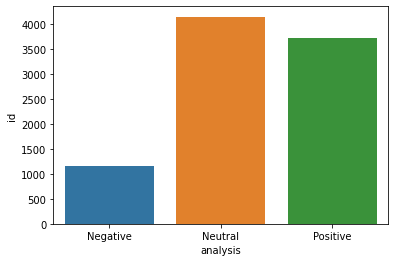

number of positve tagged sentences is:  3709
number of negative tagged sentences is: 1149
total length of the data is:            9000


<Figure size 432x288 with 0 Axes>

<Figure size 864x432 with 0 Axes>

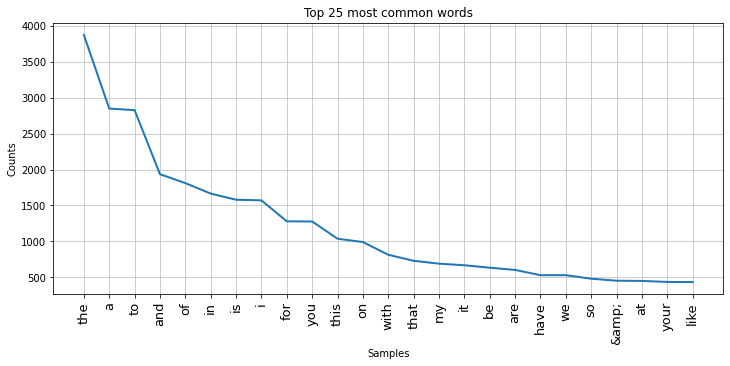

<Figure size 432x288 with 0 Axes>

/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.

/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.



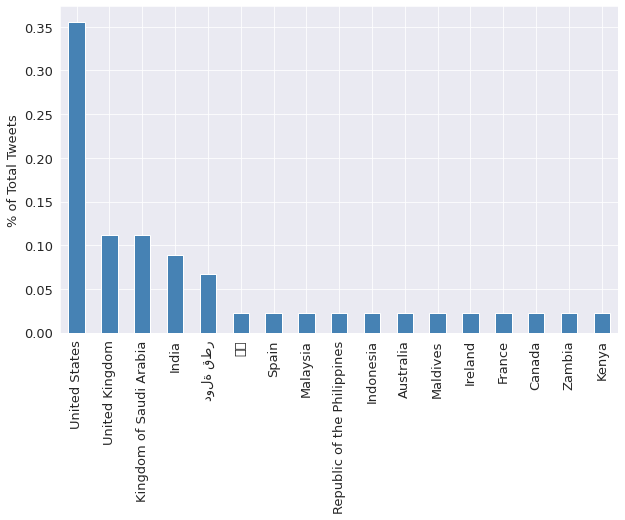

3
['states' 'Negative' 'Positive']
predictions states  Negative  Positive  total_sentiment
0               CA       0.0       2.0              2.0
1               FL       0.0       1.0              1.0
2               ID       0.0       1.0              1.0
3               MA       0.0       1.0              1.0
4               MD       0.0       1.0              1.0


In [ ]:
#if __name__ == "__main__":

# Create Spark session
spark = SparkSession.builder.appName("TwitterSentimentAnalysis").getOrCreate()

# Start batch processing
tweets = start_batch_processing(spark)

# Visualize results
visualize_results_from_batch(tweets)

In [ ]:
print(tweets.count())
tweets.createOrReplaceTempView("MyTable")

In [ ]:
df = spark.sql('SELECT count(id) FROM MyTable WHERE analysis = "Positive"')
df.show(5)

In [ ]:
df = spark.sql('SELECT count(id) FROM MyTable WHERE analysis = "Negative"')
df.show(5)

In [ ]:
df = spark.sql('SELECT count(id) FROM MyTable WHERE analysis = "Neutral"')
df.show(5)

In [ ]:
spark.stop()